#### machine learning preliminary experiment

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score, accuracy_score,recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
merged = pd.read_pickle('../dataset/merged_data_2class.pkl')
merged

,sex,age,edu,end,GAF,RIN,raw_reads,clean_reads,Q20,Q30,...,RBMY1A3P,AC126323.5,AC023824.3,AC087463.2,AL139135.2,KSR1P1,AC104454.1,AC098657.1,AC027309.3,AL732618.1
id,,,,,,,,,,,,,,,,,,,,,
n337,1,14,8,0,56,8.1,7.911602,7.901730,97.24,92.79,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n342,0,17,9,0,52,9.0,7.886186,7.877051,97.52,93.32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n346,0,17,9,0,47,8.8,7.936888,7.928224,97.39,93.09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n348,0,21,14,0,48,8.3,7.857012,7.849438,97.24,92.78,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n349,0,18,9,1,46,8.3,7.973639,7.963862,98.07,94.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n442c,1,14,8,0,66,8.8,7.989200,7.983345,97.68,93.76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n449c,0,15,9,0,72,7.9,7.994069,7.985102,97.71,93.89,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n457c,1,27,16,0,71,6.9,7.999861,7.991270,97.48,93.40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
merged = merged.reset_index(drop=False)
merged

,id,sex,age,edu,end,GAF,RIN,raw_reads,clean_reads,Q20,...,RBMY1A3P,AC126323.5,AC023824.3,AC087463.2,AL139135.2,KSR1P1,AC104454.1,AC098657.1,AC027309.3,AL732618.1
0,n337,1,14,8,0,56,8.1,7.911602,7.901730,97.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,n342,0,17,9,0,52,9.0,7.886186,7.877051,97.52,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,n346,0,17,9,0,47,8.8,7.936888,7.928224,97.39,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,n348,0,21,14,0,48,8.3,7.857012,7.849438,97.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,n349,0,18,9,1,46,8.3,7.973639,7.963862,98.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,n442c,1,14,8,0,66,8.8,7.989200,7.983345,97.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103,n449c,0,15,9,0,72,7.9,7.994069,7.985102,97.71,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,n457c,1,27,16,0,71,6.9,7.999861,7.991270,97.48,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,n465c,1,14,8,0,60,7.5,8.022328,8.013831,97.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#merged = merged.fillna(0)
from sklearn.utils import shuffle
shuffled = shuffle(merged)
shuffled = pd.read_pickle('../dataset/merged_data_shuffled_2class.pkl')
#shuffled.to_pickle('../dataset/merged_data_shuffled_2class.pkl')
labels = np.array(shuffled['end'])
features = np.array(shuffled.drop(columns=['end','id']))
print(labels.shape)
print(features.shape)

X = features
Y = labels
print(Y)

(107,)
(107, 57220)
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]


In [5]:
#shuffled.to_pickle('../dataset/merged_data_shuffled_2class.pkl')


(mean) ACC:  0.8874458874458874 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.9424129982571541
(std) ACC:  0.024792763745933092 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.020046419391161543


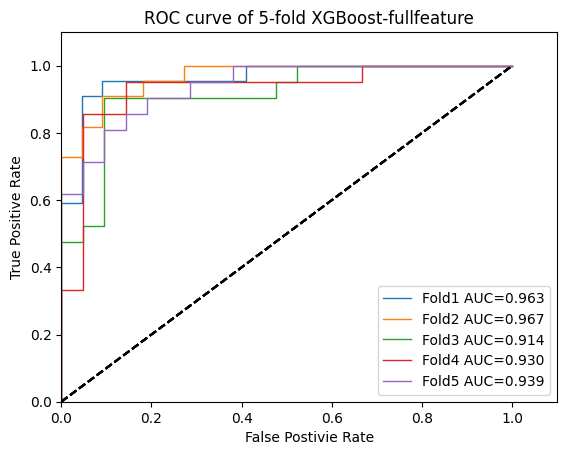

In [31]:
import xgboost as xgb
from sklearn.utils import class_weight

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=Y
)

# 5-fold
model_name = 'XGBoost'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    #clf = xgb.XGBClassifier(n_jobs=-1,n_estimators=15,max_depth=6)
    clf = xgb.XGBClassifier(n_jobs=-1)
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name + '-fullfeature')
plt.savefig('../images/class2/roc-5fold-' + model_name + '-fullfeature.png',dpi=300)
plt.show()

(mean) ACC:  0.8969696969696969 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.9261764209816157
(std) ACC:  0.020007307373664674 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.02018999850887122


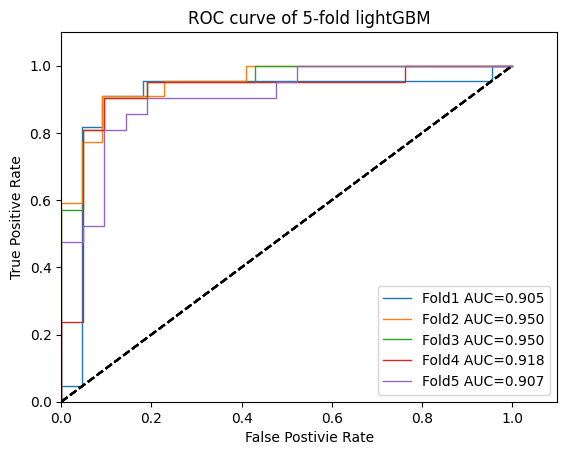

In [7]:
import lightgbm as lgb

# 5-fold
model_name = 'lightGBM'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = lgb.LGBMClassifier(n_jobs=-1)
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
#plt.savefig('images2/roc-5fold-' + year + '-' + var + '.png',dpi=300)
plt.show()

(mean) ACC:  0.8969696969696969 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.9243230074398905
(std) ACC:  0.020007307373664674 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.05039317877515184


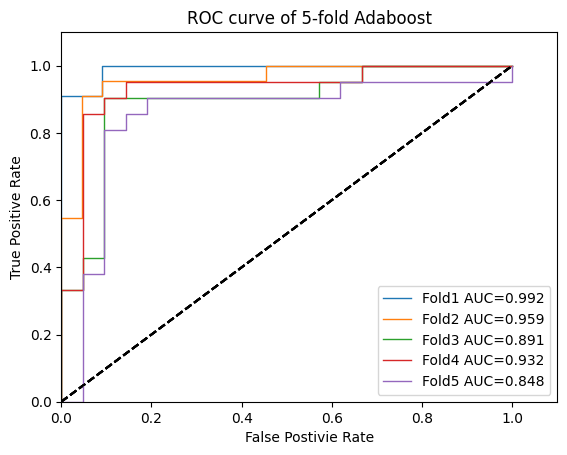

In [8]:
from sklearn.ensemble import AdaBoostClassifier

# 5-fold
model_name = 'Adaboost'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = AdaBoostClassifier()
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
#plt.savefig('images2/roc-5fold-' + year + '-' + var + '.png',dpi=300)
plt.show()

(mean) ACC:  0.8969696969696969 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.869083225576732
(std) ACC:  0.020007307373664674 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.03196471481578336


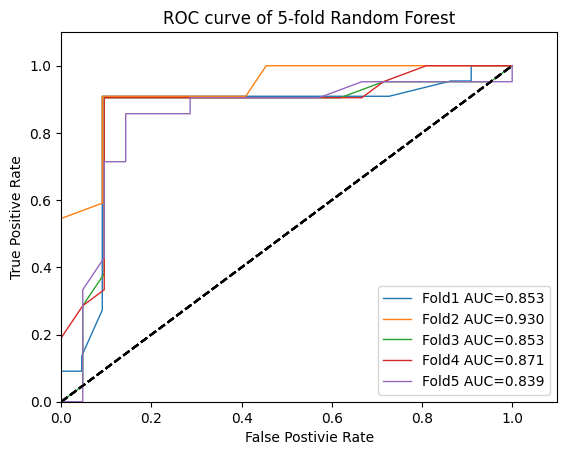

In [9]:
from sklearn.ensemble import RandomForestClassifier

# 5-fold
model_name = 'Random Forest'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = RandomForestClassifier()
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
#plt.savefig('images2/roc-5fold-' + year + '-' + var + '.png',dpi=300)
plt.show()

(mean) ACC:  0.841125541125541 Precision:  0.15 Recall:  0.16666666666666666 F1:  0.15714285714285717 AUC:  0.841125541125541
(std) ACC:  0.06305503534556926 Precision:  0.19999999999999998 Recall:  0.21081851067789198 F1:  0.20404081224408147 AUC:  0.06305503534556925


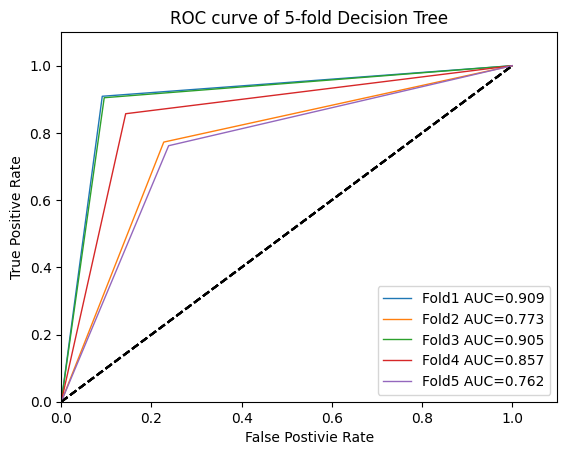

In [10]:
from sklearn.tree import DecisionTreeClassifier

# 5-fold
model_name = 'Decision Tree'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = DecisionTreeClassifier()
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
#plt.savefig('images2/roc-5fold-' + year + '-' + var + '.png',dpi=300)
plt.show()

(mean) ACC:  0.5969696969696969 Precision:  0.1408080808080808 Recall:  0.6666666666666667 F1:  0.2317016317016317 AUC:  0.5944505350349505
(std) ACC:  0.06996935293580901 Precision:  0.08161616161616161 Recall:  0.4216370213557839 F1:  0.1365704804634355 AUC:  0.08357982331401079


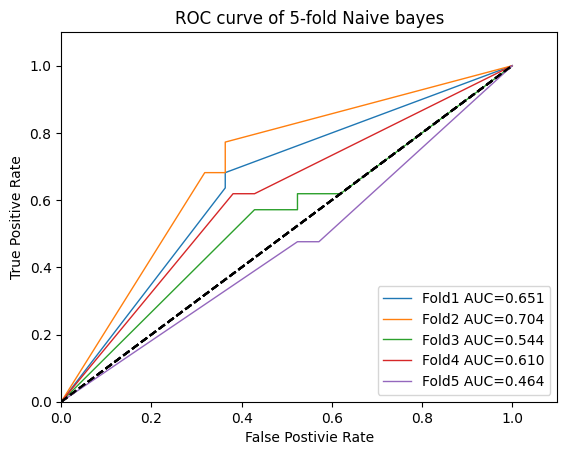

In [11]:
from sklearn.naive_bayes import GaussianNB

# 5-fold
model_name = 'Naive bayes'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = GaussianNB()
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
#plt.savefig('images2/roc-5fold-' + year + '-' + var + '.png',dpi=300)
plt.show()

(mean) ACC:  0.8683982683982684 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.9174593804463935
(std) ACC:  0.03750027329473196 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.04112036025865561


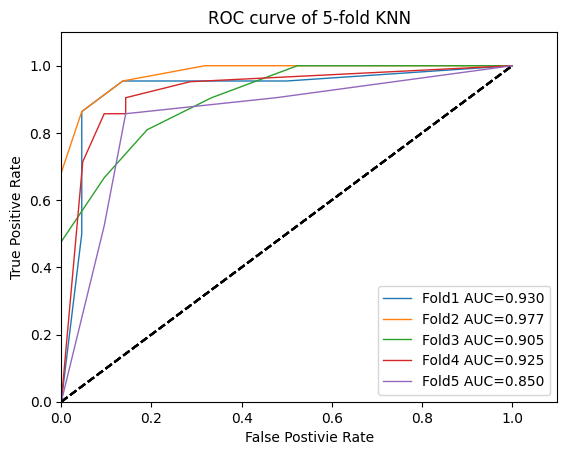

In [12]:
from sklearn.neighbors import KNeighborsClassifier

# 5-fold
model_name = 'KNN'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = KNeighborsClassifier()
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
#plt.savefig('images2/roc-5fold-' + year + '-' + var + '.png',dpi=300)
plt.show()

(mean) ACC:  0.8316017316017316 Precision:  0.04 Recall:  0.1 F1:  0.05714285714285715 AUC:  0.8696730758419069
(std) ACC:  0.038389262818000626 Precision:  0.08 Recall:  0.20000000000000004 F1:  0.11428571428571428 AUC:  0.09481826677538369


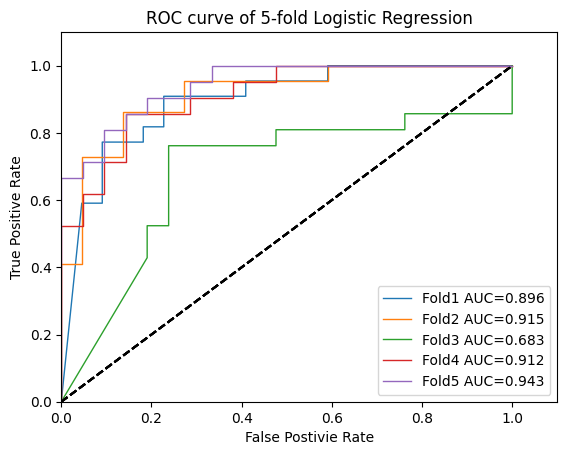

In [13]:
from sklearn.linear_model import LogisticRegression

# 5-fold
model_name = 'Logistic Regression'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    clf = LogisticRegression()
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
#plt.savefig('images2/roc-5fold-' + year + '-' + var + '.png',dpi=300)
plt.show()

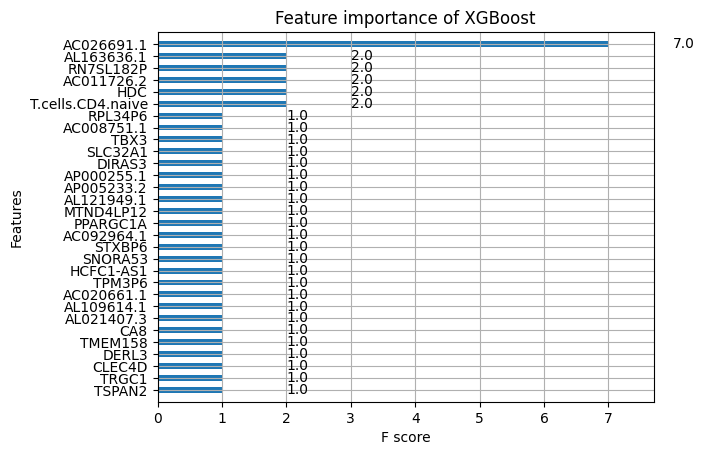

In [25]:
## feature importance
import matplotlib.pyplot as plt
%matplotlib inline

# xgboost
model_name='XGBoost'

import xgboost
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(X, Y)

feature_names = merged.drop(columns=['end','id']).columns.values.tolist()
clf.get_booster().feature_names = feature_names
xgboost.plot_importance(clf, height=0.5, max_num_features=30)
plt.title('Feature importance of '  + model_name)
plt.savefig('../images/class2/feature_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 938358
[LightGBM] [Info] Number of data points in the train set: 107, number of used features: 30319
[LightGBM] [Info] Start training from score 0.102804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

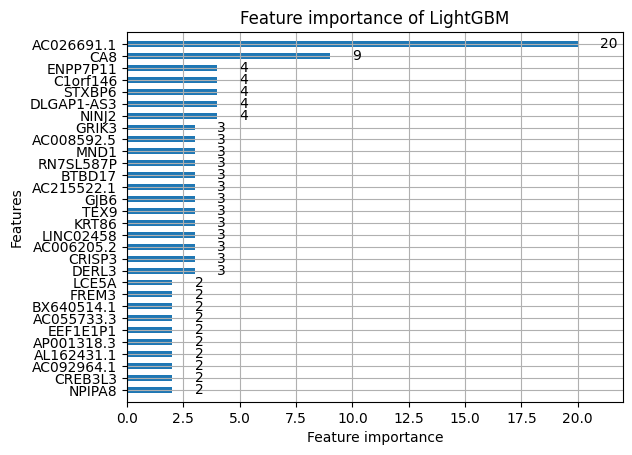

In [26]:
# lightGBM
model_name='LightGBM'
feature_names = merged.drop(columns=['end','id']).columns.values.tolist()

params = {
    'task': 'train',
    'boosting_type': 'gbdt',  
    'objective': 'regression',  
    'metric': {'auc'},  
    'num_leaves': 31,  
    'learning_rate': 0.05,  
    'feature_fraction': 0.9,  
    'bagging_fraction': 0.8,  
    'bagging_freq': 5,  
    'verbose': 1  
}

import lightgbm as lgb
train = lgb.Dataset(data=merged.drop(columns=['end','id']),label=merged['end'])
#clf = lgb.LGBMClassifier(n_jobs=-1)
clf = lgb.train(params,train)

ax = lgb.plot_importance(clf, height=0.5, max_num_features=30)
plt.title('Feature importance of '  + model_name)

plt.savefig('../images/class2/feature_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()

In [27]:
# 3-feature
feature3 = shuffled[['AC026691.1','CA8','end']]
feature3

,AC026691.1,CA8,end
25,0.398141,0.902617,0
65,0.000000,0.271260,0
71,0.158104,0.634153,0
46,0.128326,0.179031,0
100,0.000000,0.222278,0
...,...,...,...
58,0.000000,0.178123,1
41,0.301785,0.646578,0
33,0.145538,0.203044,0
32,0.031825,0.111000,0


In [28]:
y3 = np.array(feature3['end'])
x3 = np.array(feature3.drop(columns=['end']))
print(y3)

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]


(mean) ACC:  0.9437229437229437 Precision:  0.8333333333333334 Recall:  0.6333333333333333 F1:  0.7 AUC:  0.9894379790483686
(std) ACC:  0.035881152874635676 Precision:  0.21081851067789195 Recall:  0.19436506316151003 F1:  0.16329931618554522 AUC:  0.009781234550709528


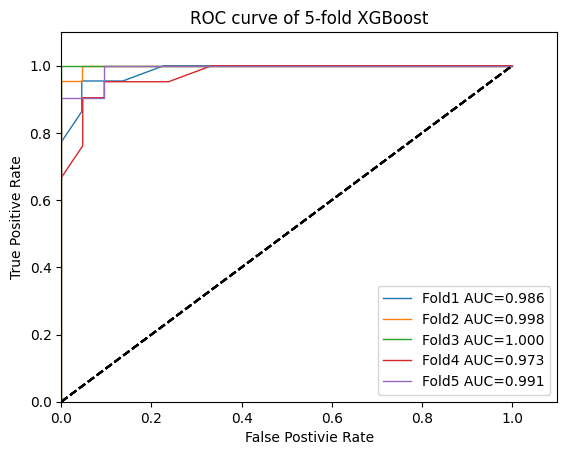

In [29]:
import xgboost as xgb

# 5-fold
model_name = 'XGBoost'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(x3):
    train_x,test_x = x3[train_index], x3[valid_index]
    train_y,test_y = y3[train_index], y3[valid_index]
    #clf = xgb.XGBClassifier(n_jobs=-1,n_estimators=15,max_depth=6)
    clf = xgb.XGBClassifier(n_jobs=-1)
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
plt.savefig('../images/class2/roc-5fold-' + model_name + '-3feature.png',dpi=300)
plt.show()

(mean) ACC:  0.8969696969696969 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.9688986338336989
(std) ACC:  0.020007307373664674 Precision:  0.0 Recall:  0.0 F1:  0.0 AUC:  0.01673419292468426


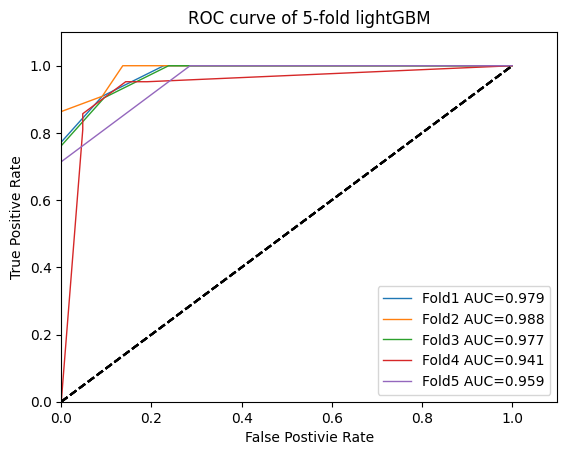

In [23]:
import lightgbm as lgb

# 5-fold
model_name = 'lightGBM'
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(x3):
    train_x,test_x = x3[train_index], x3[valid_index]
    train_y,test_y = y3[train_index], y3[valid_index]
    clf = lgb.LGBMClassifier(n_jobs=-1)
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold '  + model_name)
plt.savefig('../images/class2/roc-5fold-' + model_name + '-3feature.png',dpi=300)
plt.show()